In [52]:
library(rethinking)
library(MASS)

In [53]:
data(eagles)
eagles[,3:5] <- sapply(eagles[, 3:5], as.character)

$y$ - number of successful attempts

$n$ - total number of attempts

$P$ - size of pirating eagle (Large or Small)

$A$ - age of pirating eagle (Immature or Adult)

$V$ - size of victim eagle (Large or Small)

In [54]:
df <- eagles
dim(df)
df

[1] 8 5

y,n,P,A,V
17,24,L,A,L
29,29,L,A,S
17,27,L,I,L
20,20,L,I,S
1,12,S,A,L
15,16,S,A,S
0,28,S,I,L
1,4,S,I,S


### Encoding variables:

In [55]:
df$P <- ifelse(df$P == 'S', 0, 1) 
df$A <- ifelse(df$A == 'I', 0, 1)
df$V <- ifelse(df$V == 'S', 0, 1)
df

y,n,P,A,V
17,24,1,1,1
29,29,1,1,0
17,27,1,0,1
20,20,1,0,0
1,12,0,1,1
15,16,0,1,0
0,28,0,0,1
1,4,0,0,0


### Model definition:

$h_i \sim Binomial(n_i, p_i)$

$logit(p_i) = \alpha+\beta_PP_i+\beta_AA_i+\beta_VV_i$

$\alpha \sim Normal(0, 10)$

$\beta_P \sim Normal(0, 5)$

$\beta_A \sim Normal(0, 5)$

$\beta_V \sim Normal(0, 5)$

In [56]:
model <- alist(
    y ~ dbinom(n, p),
    logit(p) <- alpha + beta_p[P] + beta_a[A] + beta_v[V],
    alpha ~ dnorm(0, 10),
    beta_p[P] ~ dnorm(0, 5),
    beta_a[A] ~ dnorm(0, 5),
    beta_v[V] ~ dnorm(0, 5)
    )

In [57]:
quap_fitted <- map(model, data=df)

### Seems that model has not been fitted well:

In [58]:
precis(quap_fitted, depth=2)

,mean,sd,"5,5%","94,5%"
alpha,"0,308792890","6,547201","-10,154898","10,772484"
beta_p[1],"0,060391914","4,629159","-7,337898","7,458682"
beta_p[2],"-0,004238488","5,000000","-7,995204","7,986727"
beta_a[1],"0,069117620","4,629159","-7,329173","7,467408"
beta_a[2],"-0,002127949","5,000000","-7,993094","7,988838"
beta_v[1],"0,072439068","4,629159","-7,325851","7,470729"
beta_v[2],"-0,001735435","5,000000","-7,992701","7,989230"


In [59]:
post_qual <- extract.samples(quap_fitted)

In [60]:
get_probs <- function(preds, data){
    probs <- list()
    for (row in 1:nrow(data)){
        curr <- data[row,]
        out <- (preds$alpha + 
                preds$beta_p[,-(curr[,3]+1)] + 
                preds$beta_a[,-(curr[,4]+1)] + 
                preds$beta_v[,-(curr[,5]+1)])
        probs[[row]] <- inv_logit(out)
    }
    probs
}

get_counts <- function(preds, data){
    counts <- list()
    for (row in 1:nrow(data)){
        curr <- data[row,]
        out <- (preds$alpha + 
                preds$beta_p[,-(curr[,3]+1)] + 
                preds$beta_a[,-(curr[,4]+1)] + 
                preds$beta_v[,-(curr[,5]+1)])
        probs <- inv_logit(out)
        counts[[row]] <- data[row, 2] * probs
    }
    counts
}

In [61]:
q_probs <- get_probs(post_qual, df)
q_counts <- get_counts(post_qual, df)

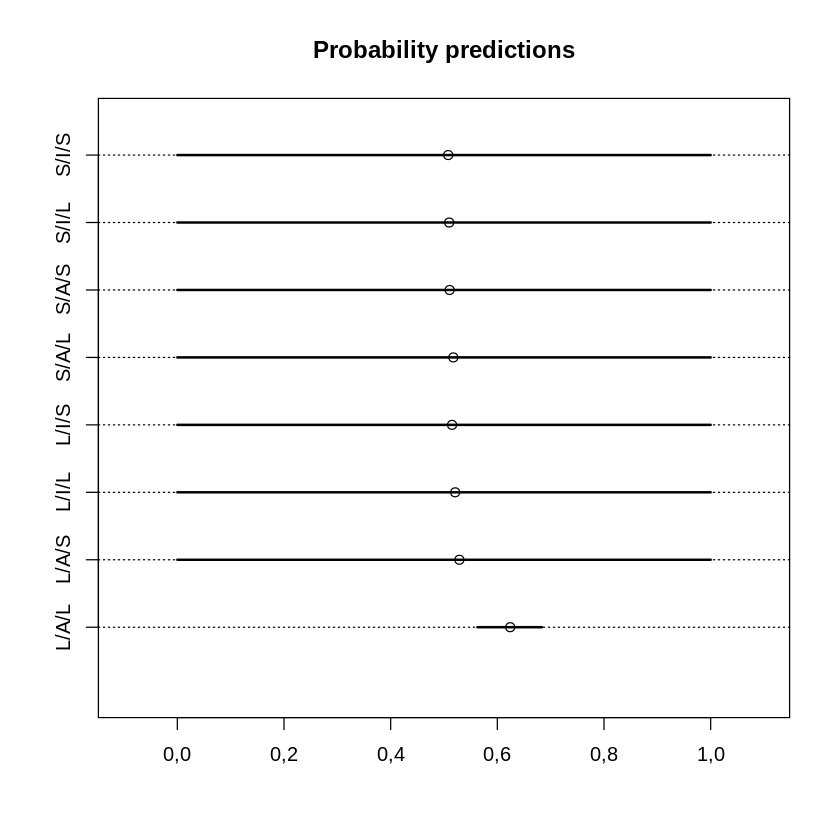

In [62]:
plot(1, type="n", yaxt='n', xlab="", ylab="", xlim=c(-0.1, 1.1), ylim=c(0, 17),
    main='Probability predictions')

y_ticks <- list()
for (row in 1:nrow(df)){
    mean_val <- mean(q_probs[[row]])
    interval <- PI(q_probs[[row]], prob=0.89)
    segments(interval[1], 2*row, interval[2], 2*row, lwd=2)
    points(mean_val, 2*row)
    abline(h=2*row, lty='dotted')
    y_ticks[row] <- paste(eagles[row, 3:5], collapse='/')
}
axis(2, at=seq(2, 16, 2), labels=y_ticks)

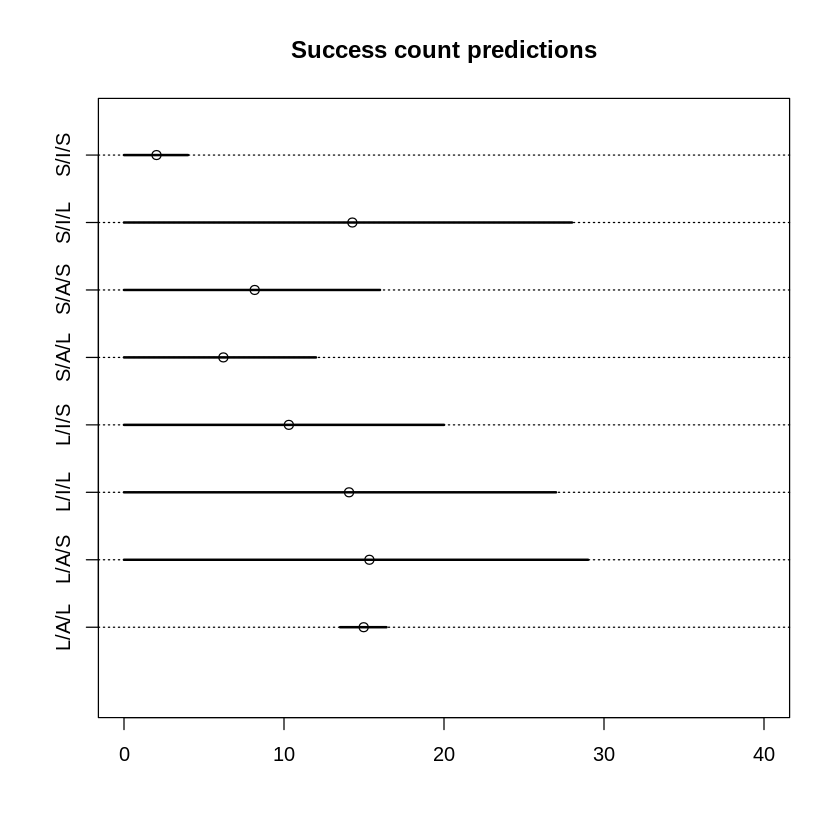

In [63]:
plot(1, type="n", yaxt='n', xlab="", ylab="", xlim=c(0, 40), ylim=c(0, 17),
    main='Success count predictions')

y_ticks <- list()
for (row in 1:nrow(df)){
    mean_val <- mean(q_counts[[row]])
    interval <- PI(q_counts[[row]], prob=0.89)
    segments(interval[1], 2*row, interval[2], 2*row, lwd=2)
    points(mean_val, 2*row)
    abline(h=2*row, lty='dotted')
    y_ticks[row] <- paste(eagles[row, 3:5], collapse='/')
}
axis(2, at=seq(2, 16, 2), labels=y_ticks)

### Fitting with MCMC:

In [64]:
MCMC_fitted <- map2stan(model, data=eagles, chains=4)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”


SAMPLING FOR MODEL '0f5eeb0be88582383bac5d5bd64d2751' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.494712 seconds (Warm-up)
Chain 1:                0.552957 seconds (Sampling)


Computing WAIC


In [65]:
precis(MCMC_fitted, depth=2)

,mean,sd,"5,5%","94,5%",n_eff,Rhat
alpha,"0,7766175","5,262305","-7,469838","9,111251","1633,325","1,0006647"
beta_p[1],"2,3297378","3,399823","-3,097573","7,761723","1742,039","0,9998523"
beta_p[2],"-2,5262467","3,449663","-8,081794","2,967872","1699,094","0,9996655"
beta_a[1],"0,7214264","3,329830","-4,674441","6,030953","1952,733","1,0012417"
beta_a[2],"-0,4266815","3,327254","-5,716911","4,908706","1961,022","1,0010524"
beta_v[1],"-2,4420863","3,514118","-8,233502","2,901007","1819,392","0,9999077"
beta_v[2],"2,8403176","3,523369","-2,894811","8,367821","1869,618","1,0000275"


In [66]:
mc_preds <- extract.samples(MCMC_fitted)

In [67]:
mc_probs <- get_probs(mc_preds, df)
mc_counts <- get_counts(mc_preds, df)

In [68]:
eagles

y,n,P,A,V
17,24,L,A,L
29,29,L,A,S
17,27,L,I,L
20,20,L,I,S
1,12,S,A,L
15,16,S,A,S
0,28,S,I,L
1,4,S,I,S


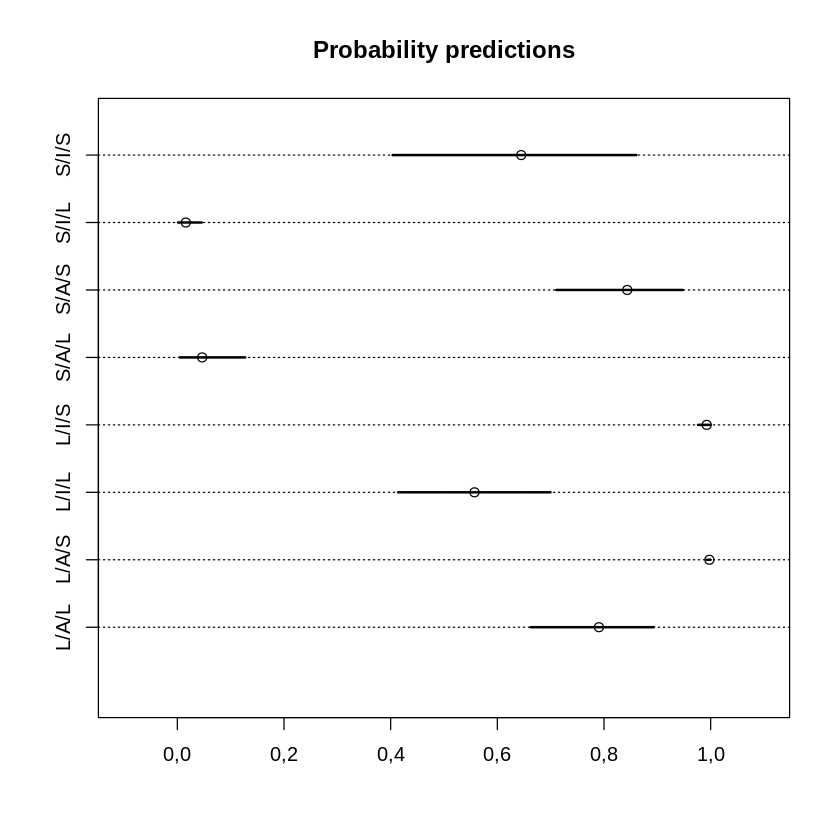

In [69]:
plot(1, type="n", yaxt='n', xlab="", ylab="", xlim=c(-0.1, 1.1), ylim=c(0, 17),
    main='Probability predictions')

y_ticks <- list()
for (row in 1:nrow(df)){
    mean_val <- mean(mc_probs[[row]])
    interval <- PI(mc_probs[[row]], prob=0.89)
    segments(interval[1], 2*row, interval[2], 2*row, lwd=2)
    points(mean_val, 2*row)
    abline(h=2*row, lty='dotted')
    y_ticks[row] <- paste(eagles[row, 3:5], collapse='/')
}
axis(2, at=seq(2, 16, 2), labels=y_ticks)

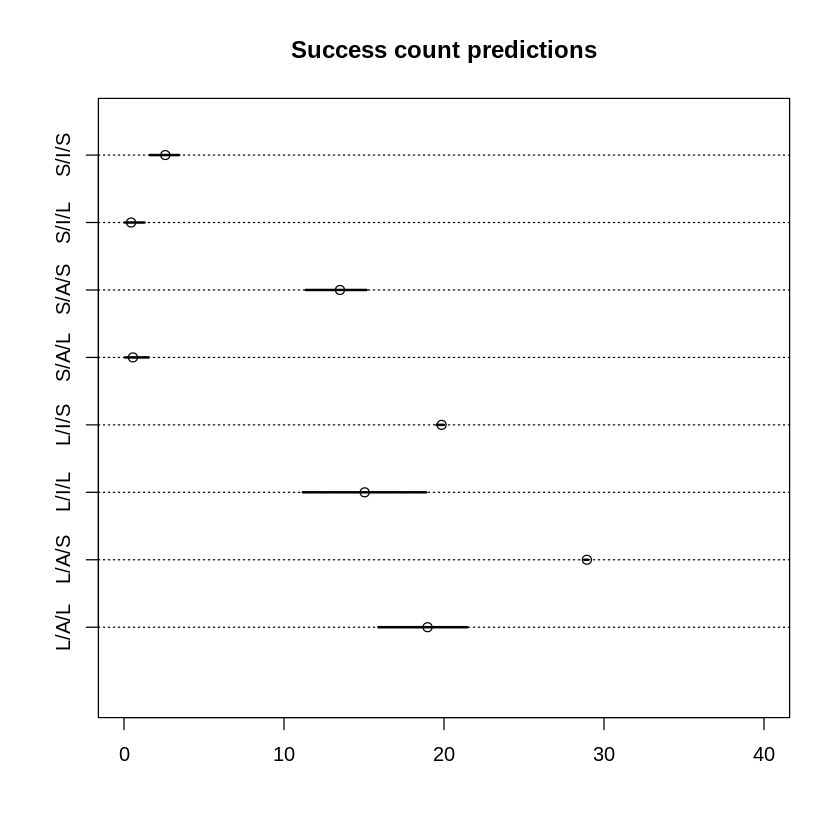

In [70]:
plot(1, type="n", yaxt='n', xlab="", ylab="", xlim=c(0, 40), ylim=c(0, 17),
    main='Success count predictions')

y_ticks <- list()
for (row in 1:nrow(df)){
    mean_val <- mean(mc_counts[[row]])
    interval <- PI(mc_counts[[row]], prob=0.89)
    segments(interval[1], 2*row, interval[2], 2*row, lwd=2)
    points(mean_val, 2*row)
    abline(h=2*row, lty='dotted')
    y_ticks[row] <- paste(eagles[row, 3:5], collapse='/')
}
axis(2, at=seq(2, 16, 2), labels=y_ticks)

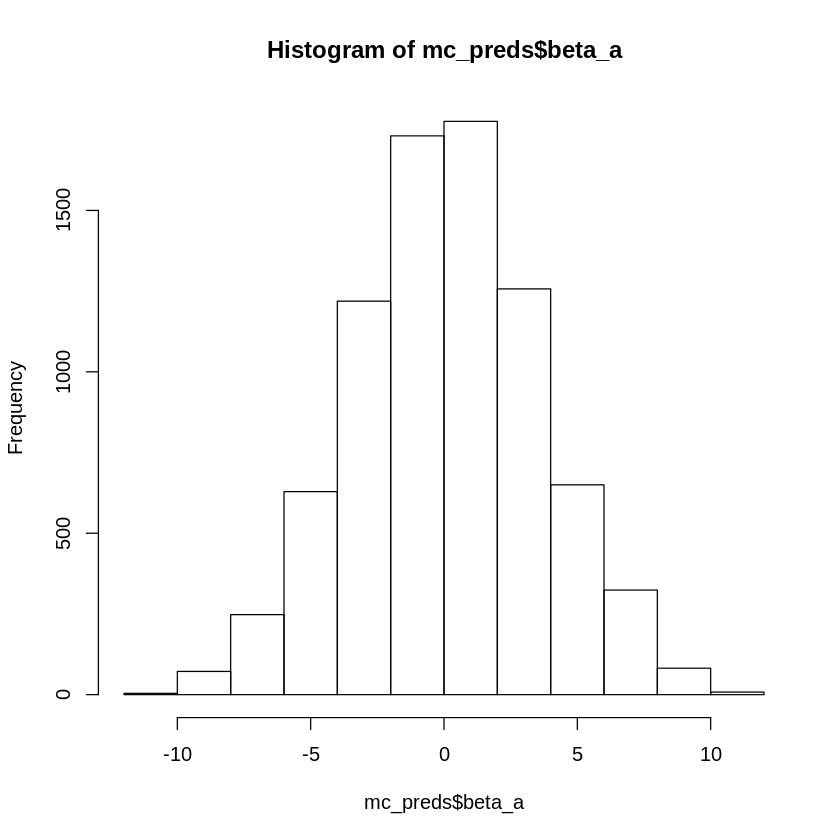

In [43]:
hist(mc_preds$beta_a)

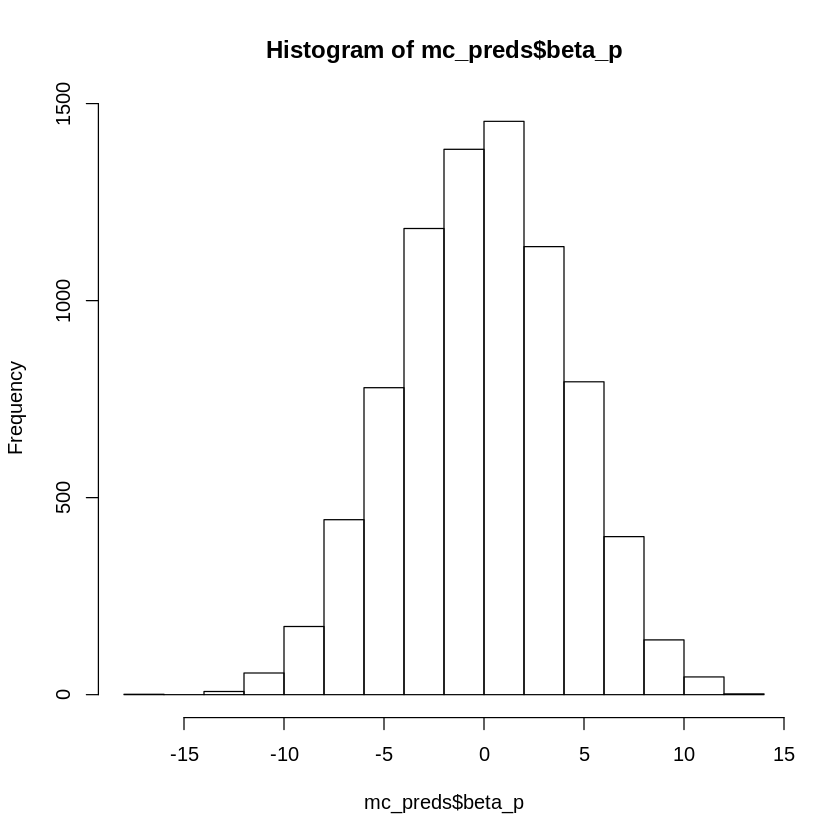

In [71]:
hist(mc_preds$beta_p)

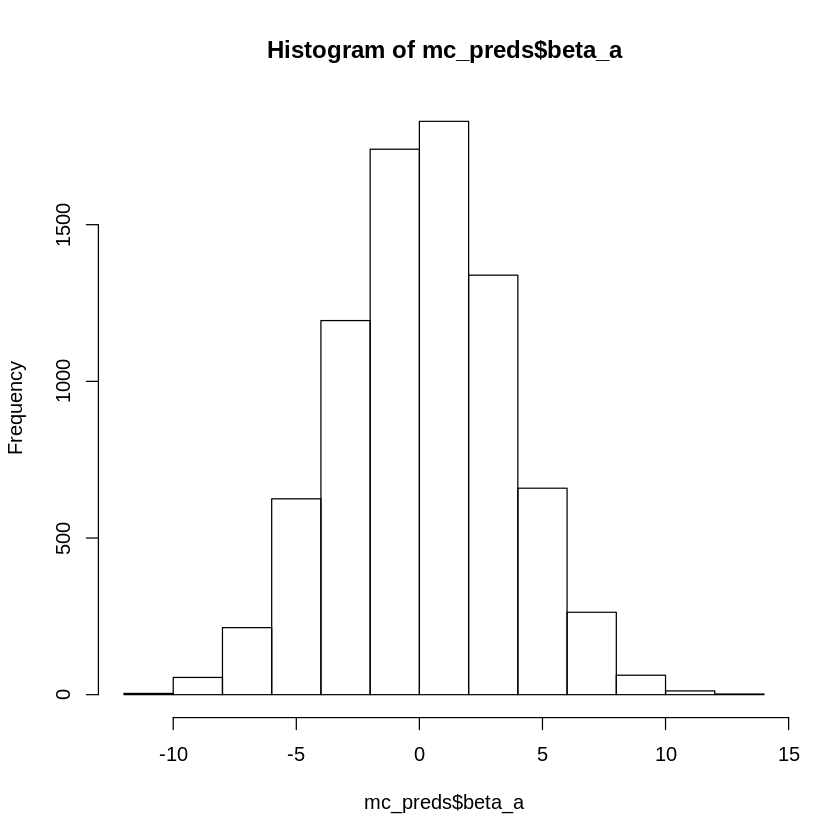

In [72]:
hist(mc_preds$beta_a)

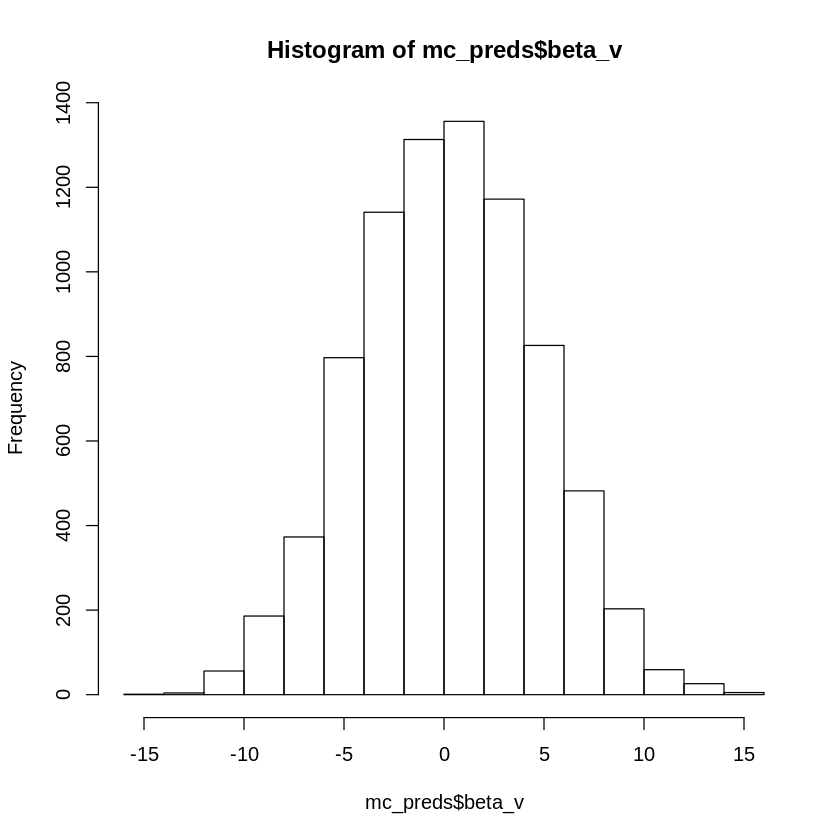

In [73]:
hist(mc_preds$beta_v)